# 5. Dependency Parsing 

* http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture6.pdf
* http://cs.stanford.edu/people/danqi/papers/emnlp2014.pdf
* https://github.com/rguthrie3/DeepDependencyParsingProblemSet/tree/master/data

In [132]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
flatten = lambda l: [item for sublist in l for item in sublist]

In [3]:
USE_CUDA = torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [4]:
def getBatch(batch_size,train_data):
    random.shuffle(train_data)
    sindex=0
    eindex=batch_size
    while eindex < len(train_data):
        batch = train_data[sindex:eindex]
        temp = eindex
        eindex = eindex+batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [10]:
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if w in to_index.keys() else to_index["<unk>"], seq))
    return Variable(LongTensor(idxs))

In [131]:
class TrainsitionState(object):
    
    def __init__(self,tagged_sent):
        self.root = ('ROOT','<root>',-1)
        self.stack=[self.root]
        self.buffer=[(s[0],s[1],i) for i,s in enumerate(tagged_sent)]
        self.address = [s[0] for s in tagged_sent] + [self.root[0]]
        self.arcs=[]
        self.terminal=False
        
    def __str__(self):
        return 'stack : %s \nbuffer : %s' % (str([s[0] for s in self.stack]), str([b[0] for b in self.buffer]))
    
    def shift(self):
        
        if len(self.buffer)>=1:
            self.stack.append(self.buffer.pop(0))
        else:
            print("Empty buffer")
            
    def left_arc(self,relation=None):
        
        if len(self.stack)>=2:
            arc={}
            s2 = self.stack[-2]
            s1 = self.stack[-1]
            arc['graph_id'] = len(self.arcs)
            arc['form'] = s1[0]
            arc['addr'] = s1[2]
            arc['head']=s2[2]
            arc['pos'] = s1[1]
            if relation:
                arc['relation']=relation
            self.arcs.append(arc)
            self.stack.pop(-2)
            
        elif self.stack==[self.root]:
            print("Element Lacking")
    
    def right_arc(self,relation=None):
        
        if len(self.stack)>=2:
            arc={}
            s2 = self.stack[-2]
            s1 = self.stack[-1]
            arc['graph_id'] = len(self.arcs)
            arc['form'] = s2[0]
            arc['addr'] = s2[2]
            arc['head']=s1[2]
            arc['pos'] = s2[1]
            if relation:
                arc['relation']=relation
            self.arcs.append(arc)
            self.stack.pop(-1)
            
        elif self.stack==[self.root]:
            print("Element Lacking")
    
    def get_left_most(self,index):
        left=['<NULL>','<NULL>',None]
        
        if index==None: return left
        for arc in self.arcs:
            if arc['head']==index:
                left=[arc['form'],arc['pos'],arc['addr']]
                break
        return left
    
    def get_right_most(self,index):
        right=['<NULL>','<NULL>',None]
        
        if index==None: return right
        for arc in reversed(self.arcs):
            if arc['head']==index:
                right=[arc['form'],arc['pos'],arc['addr']]
                break
        return right
    
    def is_done(self):
        return len(self.buffer)==0 and self.stack==[self.root]
    
    def to_tree(self):
        if self.is_done()==False: return None
        tree_dict=OrderedDict()
        for arc in self.arcs:
            if arc['form'] in tree_dict.keys():
                tree_dict[arc['form']].append(self.address[arc['head']])
            elif arc['form']!='ROOT':
                tree = self.address[arc['head']]
                tree_dict[arc['form']]=[tree]
        
        return tree_dict

This is an example of transition-based dependancy parsing in the paper. Model's goal is to predict correct transition of parser.

In [12]:
temp = TrainsitionState(nltk.pos_tag("He has good control .".split()))
print(temp)
temp.shift()
temp.shift()
print(temp)
temp.left_arc()
print(temp)
print(temp.arcs)
temp.shift()
temp.shift()
print(temp)
temp.left_arc()
print(temp)
temp.right_arc()
print(temp)
temp.shift()
temp.right_arc()
print(temp)
temp.right_arc()
print(temp)
print(temp.arcs)
temp.is_done()

stack : ['ROOT'] 
buffer : ['He', 'has', 'good', 'control', '.']
stack : ['ROOT', 'He', 'has'] 
buffer : ['good', 'control', '.']
stack : ['ROOT', 'has'] 
buffer : ['good', 'control', '.']
[{'addr': 1, 'head': 0, 'pos': 'VBZ', 'graph_id': 0, 'form': 'has'}]
stack : ['ROOT', 'has', 'good', 'control'] 
buffer : ['.']
stack : ['ROOT', 'has', 'control'] 
buffer : ['.']
stack : ['ROOT', 'has'] 
buffer : ['.']
stack : ['ROOT', 'has'] 
buffer : []
stack : ['ROOT'] 
buffer : []
[{'addr': 1, 'head': 0, 'pos': 'VBZ', 'graph_id': 0, 'form': 'has'}, {'addr': 3, 'head': 2, 'pos': 'NN', 'graph_id': 1, 'form': 'control'}, {'addr': 1, 'head': 3, 'pos': 'VBZ', 'graph_id': 2, 'form': 'has'}, {'addr': 1, 'head': 4, 'pos': 'VBZ', 'graph_id': 3, 'form': 'has'}, {'addr': -1, 'head': 1, 'pos': '<root>', 'graph_id': 4, 'form': 'ROOT'}]


True

# Data load & Preprocessing 

Get features from stack and buffer. <br>
1.  The top 3 words on the stack and buffer ($s_1,s_2,s_3,b_1,b_2,b_3$)
2. The first and second leftmost / rightmost children of the top two words on the stack: $lc_1(s_i), rc_1(s_i), lTc_2(s_i), rc_2(s_i), i = 1, 2$
3. <i>The leftmost of leftmost / rightmost of rightmost children of the top two words on the stack: $lc_1(lc_1(s_i)), rc_1(rc_1(s_i)), i = 1, 2$. # I don't use these features</i>
4. POS tags for $S^t$
5. <i>corresponding arc labels of words excluding those 6 words on the stack/buffer for $S^l$ # I don't use these features</i>

In [13]:
def get_feat(transition_state,word2index,tag2index,label2index=None):
    word_feats=[]
    tag_feats = []
    
    word_feats.append(transition_state.stack[-1][0]) if len(transition_state.stack)>=1 and \
    transition_state.stack[-1][0] in word2index.keys() else word_feats.append('<NULL>') # s1
    word_feats.append(transition_state.stack[-2][0]) if len(transition_state.stack)>=2 and \
    transition_state.stack[-2][0] in word2index.keys() else word_feats.append('<NULL>') # s2
    word_feats.append(transition_state.stack[-3][0]) if len(transition_state.stack)>=3 and \
    transition_state.stack[-3][0] in word2index.keys() else word_feats.append('<NULL>') # s3
    
    tag_feats.append(transition_state.stack[-1][1]) if len(transition_state.stack)>=1 and \
    transition_state.stack[-1][1] in tag2index.keys() else tag_feats.append('<NULL>') # st1
    tag_feats.append(transition_state.stack[-2][1]) if len(transition_state.stack)>=2 and \
    transition_state.stack[-2][1] in tag2index.keys() else tag_feats.append('<NULL>') # st2
    tag_feats.append(transition_state.stack[-3][1]) if len(transition_state.stack)>=3 and \
    transition_state.stack[-3][1] in tag2index.keys() else tag_feats.append('<NULL>') # st3
    
    
    word_feats.append(transition_state.buffer[0][0]) if len(transition_state.buffer)>=1 and \
    transition_state.buffer[0][0] in word2index.keys() else word_feats.append('<NULL>') # b1
    word_feats.append(transition_state.buffer[1][0]) if len(transition_state.buffer)>=2 and \
    transition_state.buffer[1][0] in word2index.keys() else word_feats.append('<NULL>') # b2
    word_feats.append(transition_state.buffer[2][0]) if len(transition_state.buffer)>=3 and \
    transition_state.buffer[2][0] in word2index.keys() else word_feats.append('<NULL>') # b3
    
    tag_feats.append(transition_state.buffer[0][1]) if len(transition_state.buffer)>=1 and \
    transition_state.buffer[0][1] in tag2index.keys() else tag_feats.append('<NULL>') # bt1
    tag_feats.append(transition_state.buffer[1][1]) if len(transition_state.buffer)>=2 and \
    transition_state.buffer[1][1] in tag2index.keys() else tag_feats.append('<NULL>') # bt2
    tag_feats.append(transition_state.buffer[2][1]) if len(transition_state.buffer)>=3 and \
    transition_state.buffer[2][1] in tag2index.keys() else tag_feats.append('<NULL>') # bt3
    
    
    lc_s1 = transition_state.get_left_most(transition_state.stack[-1][2]) if len(transition_state.stack)>=1 \
    else transition_state.get_left_most(None)
    rc_s1 = transition_state.get_right_most(transition_state.stack[-1][2]) if len(transition_state.stack)>=1 \
    else transition_state.get_right_most(None)
    
    lc_s2 = transition_state.get_left_most(transition_state.stack[-2][2]) if len(transition_state.stack)>=2 \
    else transition_state.get_left_most(None)
    rc_s2 = transition_state.get_right_most(transition_state.stack[-2][2]) if len(transition_state.stack)>=2 \
    else transition_state.get_right_most(None)
    
    words, tags, _ = zip(*[lc_s1,rc_s1,lc_s2,rc_s2])
    
    word_feats.extend(words)
    
    tag_feats.extend(tags)
    
    
    return prepare_sequence(word_feats,word2index).view(1,-1), prepare_sequence(tag_feats,tag2index).view(1,-1)

You can get data from <a href="https://github.com/rguthrie3/DeepDependencyParsingProblemSet">this repo</a>.

In [14]:
data = open('../DeepDependencyParsingProblemSet/data/train.txt','r').readlines()
vocab = open('../DeepDependencyParsingProblemSet/data/vocab.txt','r').readlines()

In [16]:
splited_data = [[nltk.pos_tag(d.split('|||')[0].split()), d.split('|||')[1][:-1].split()] for d in data]

### Build Vocab

In [18]:
train_x,train_y = list(zip(*splited_data))
train_x_f = flatten(train_x)
sents,pos_tags = list(zip(*train_x_f))

In [19]:
tag2index = {v:i for i,v in enumerate(set(pos_tags))}
tag2index['<root>']=len(tag2index)
tag2index['<NULL>']=len(tag2index)

In [20]:
vocab = [v.split('\t')[0] for v in vocab]
word2index = {v:i for i,v in enumerate(vocab)}
word2index['ROOT'] = len(word2index)
word2index['<NULL>'] = len(word2index)

In [21]:
actions = ['SHIFT','REDUCE_L','REDUCE_R']
action2index = {v:i for i,v in enumerate(actions)}

In [22]:
train_data=[]

In [23]:
for tx,ty in splited_data:
    state = TrainsitionState(tx)
    transition = ty+['REDUCE_R'] # root
    while len(transition)!=0:
        feat = get_feat(state,word2index,tag2index)
        action = transition.pop(0)
        actionTensor = Variable(LongTensor([action2index[action]])).view(1,-1)
        train_data.append([feat,actionTensor])
        if action=='SHIFT':
            state.shift()
        elif action=='REDUCE_R':
            state.right_arc()
        elif action=='REDUCE_L':
            state.left_arc()

In [17]:
train_data[0]

[(Variable containing:
   9151  9152  9152  2106     2   353  9152  9152  9152  9152
  [torch.LongTensor of size 1x10], Variable containing:
     43    44    44    21    28    29    44    44    44    44
  [torch.LongTensor of size 1x10]), Variable containing:
  0
 [torch.LongTensor of size 1x1]]

### Modeling 

In [24]:
class NeuralDependencyParser(nn.Module):
    
    def __init__(self,w_size,w_embed_dim,t_size,t_embed_dim,hidden_size,target_size):
        
        super(NeuralDependencyParser, self).__init__()
        
        self.w_embed =  nn.Embedding(w_size,w_embed_dim)
        self.t_embed = nn.Embedding(t_size,t_embed_dim)
        self.hidden_size = hidden_size
        self.target_size = target_size
        self.linear = nn.Linear((w_embed_dim+t_embed_dim)*10,self.hidden_size)
        self.out = nn.Linear(self.hidden_size,self.target_size)
        
        self.w_embed.weight.data.uniform_(-0.01, 0.01) # init
        self.t_embed.weight.data.uniform_(-0.01, 0.01) # init
        
    def forward(self,words,tags):
        
        wem = self.w_embed(words).view(words.size(0),-1)
        tem = self.t_embed(tags).view(tags.size(0),-1)
        inputs = torch.cat([wem,tem],1)
        h1 = torch.pow(self.linear(inputs),3) # cube activation function
        preds = -self.out(h1)
        return F.log_softmax(preds)

### Training

In [25]:
STEP = 5
BATCH_SIZE=256
W_EMBED_SIZE = 50
T_EMBED_SIZE = 10
HIDDEN_SIZE=512
LR = 0.001

In [27]:
model = NeuralDependencyParser(len(word2index),W_EMBED_SIZE,len(tag2index),T_EMBED_SIZE,HIDDEN_SIZE,len(action2index))
if USE_CUDA:
    model = model.cuda()

loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr=LR)

In [28]:
losses=[]

In [29]:
for i, batch in enumerate(getBatch(BATCH_SIZE,train_data)):
    
    model.zero_grad()
    inputs, targets = list(zip(*batch))
    words, tags = list(zip(*inputs))
    words = torch.cat(words)
    tags = torch.cat(tags)
    targets = torch.cat(targets)
    preds = model(words,tags)
    loss = loss_function(preds,targets.view(-1))
    loss.backward()
    optimizer.step()
    
    losses.append(loss.data.cpu().tolist()[0] if USE_CUDA else loss.data.tolist()[0])
    
    if i % 100==0:
        print("mean_loss : %0.2f" %(np.mean(losses)))
        losses=[]

mean_loss : 1.10
mean_loss : 0.81
mean_loss : 0.38
mean_loss : 0.32
mean_loss : 0.30
mean_loss : 0.27
mean_loss : 0.26
mean_loss : 0.25
mean_loss : 0.24
mean_loss : 0.23
mean_loss : 0.21
mean_loss : 0.22
mean_loss : 0.21
mean_loss : 0.20
mean_loss : 0.20
mean_loss : 0.19


### Test (UAS)

In [30]:
dev = open('../DeepDependencyParsingProblemSet/data/dev.txt','r').readlines()

In [31]:
splited_data = [[nltk.pos_tag(d.split('|||')[0].split()), d.split('|||')[1][:-1].split()] for d in dev]

In [32]:
dev_data=[]

In [33]:
for tx,ty in splited_data:
    state = TrainsitionState(tx)
    transition = ty+['REDUCE_R'] # root
    while len(transition)!=0:
        feat = get_feat(state,word2index,tag2index)
        action = transition.pop(0)
        dev_data.append([feat,action2index[action]])
        if action=='SHIFT':
            state.shift()
        elif action=='REDUCE_R':
            state.right_arc()
        elif action=='REDUCE_L':
            state.left_arc()

In [37]:
accuracy=0

In [38]:
for dev in dev_data:
    input, target = dev[0], dev[1]
    word, tag = input[0], input[1]
    pred = model(word,tag).max(1)[1]
    pred = pred.data.cpu().tolist()[0] if USE_CUDA else pred.data.tolist()[0]
    if pred==target:
        accuracy+=1

print(accuracy/len(dev_data)*100)

91.50124069478908


### Simple plotting

In [45]:
from nltk.tree import Tree
from nltk.draw.tree import TreeView

In [135]:
import pydot

In [143]:
def plot_tree(state,image_name):
    graph = pydot.Dot(graph_type='graph')
    for arc in state.arcs:
        if arc['form']=='ROOT': continue
        edge = pydot.Edge(arc['form'],state.address[arc['head']])
        graph.add_edge(edge)
    
    graph.write_png('images/'+image_name+'.png')

In [136]:
test = TrainsitionState(nltk.pos_tag("I shot an elephant in my pajamas".split()))

In [137]:
index2action = {i:v for v,i in action2index.items()}

In [138]:
while test.is_done()==False:
    feat = get_feat(test,word2index,tag2index)
    word,tag = feat[0],feat[1]
    action = model(word,tag).max(1)[1].data.cpu().tolist()[0] if USE_CUDA \
    else model(word,tag).max(1)[1].data.tolist()[0]
    
    action = index2action[action]
    
    if action=='SHIFT':
        test.shift()
    elif action=='REDUCE_R':
        test.right_arc()
    elif action=='REDUCE_L':
        test.left_arc()

In [139]:
print(test)

stack : ['ROOT'] 
buffer : []


In [144]:
plot_tree(test,'dependacy_parse')

In [145]:
from IPython.display import Image

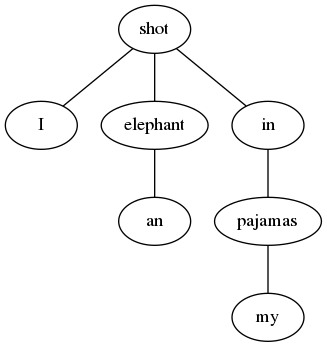

In [146]:
Image('images/dependacy_parse.png',width=300)

### TODO

* 다른  PTB 구할 수 있는지 알아보고 적용해보기 (LAS)까지 해보게..
* 헬퍼 함수나 변수명 통일화를 하자
* 부연설명 등을 좀 적어야 할듯..?
* dependancy parser 를 위한 플롯팅 예쁘게 하는거 없는지 알아보기